# タスク別前処理（マーケティング)

In [35]:
# コード5.1 本章で共通して利用するライブラリ
import pandas as pd
from datetime import datetime

# 返品処理

In [36]:
from datetime import timedelta

# コード 5.2 返品の処理
df=pd.read_csv('in/cancel.csv',parse_dates=['日付'])
display(df)

# 返品行の選択
henpin=df[df['金額']<0].rename(columns={'日付':'返金日'})
henpin['金額']=henpin['金額']*-1

# 返品日を結合して返品からの日数を求める
df=df[df['金額']>=0]
df=df.merge(henpin, on=['モニタ','細分類名','金額'],how='outer')
df['日数']=df['返金日']-df['日付']

# 返品対象商品の選択(複数の同一商品が存在する場合があるのでheadで1つ選ぶ)
sel=df[df['日数']>=timedelta(days=0)]
sel=sel.sort_values(['日数']).groupby(['モニタ','細分類名','金額']).head(1)

# 返品対象商品の消し込み
df=df.drop(index=list(sel.index))
df=df[['モニタ','日付','金額','細分類名']].sort_values(['モニタ','日付'])
display(df)

,モニタ,日付,金額,細分類名
0,A,2014-04-01,300,牛乳
1,A,2014-04-01,200,ヨーグルト
2,A,2014-04-01,-300,牛乳
3,A,2014-04-03,400,半生菓子
4,B,2014-04-08,900,ワイン
5,B,2014-04-11,900,ワイン
6,B,2014-04-11,900,ワイン
7,B,2014-04-15,800,牛肉
8,B,2014-04-17,-900,ワイン
9,B,2014-04-18,900,ワイン


,モニタ,日付,金額,細分類名
1,A,2014-04-01,200,ヨーグルト
2,A,2014-04-03,400,半生菓子
3,B,2014-04-08,900,ワイン
5,B,2014-04-11,900,ワイン
7,B,2014-04-15,800,牛肉
6,B,2014-04-18,900,ワイン
8,C,2014-05-08,200,ヨーグルト
9,C,2014-05-25,900,ワイン
10,C,2014-05-28,1000,牛肉


# 名称のクリーニング

In [37]:
# コード5.3 名称のクリーニング

import re

def mkNames(df):
        chgName=[]
        for name in df['名称']:
            name=re.sub(u'[１２３４５６７８９０．]+グラム','',name)
            name=re.sub(u'[１２３４５６７８９０．]+ｋｇ','',name)
            name=re.sub(u'[１２３４５６７８９０．]+Ｋｇ','',name)
            name=re.sub(u'[１２３４５６７８９０．]+ＫＧ','',name)
            name=re.sub(u'[１２３４５６７８９０．]+ｍｌ','',name)
            name=re.sub(u'[１２３４５６７８９０．]+袋','',name)
            name=re.sub(u'[１２３４５６７８９０．]+本','',name)
            name=re.sub(u'[１２３４５６７８９０．]+缶','',name)
            name=re.sub(u'[１２３４５６７８９０．]+人前','',name)
            name=re.sub(u'[１２３４５６７８９０．]+ｇ','',name)
            name=re.sub(u'[×]$','',name)
            chgName.append(name)
            
        dfo=pd.DataFrame(chgName,columns=(['略称']))
        return(dfo)

df=pd.read_csv('in/itemMaster.csv')
df=df.loc[:,['名称']]
display(df)

odf=mkNames(df)
display(odf)
odf.to_csv('in/itemMaster2.csv')

,名称
0,あきたこまちブレンド １袋 ５ＫＧ
1,あずさワイン 無添加マスカット ７２０ｍｌ
2,いなば とりごぼう ７５ｇ×３缶
3,おやつごろ 村田製菓 芋けんぴ 袋 １００グラム
4,カルビー ポテトチップスうすしお ８０ｇ
5,カルビー ポテトチップスたらこバター ５８ｇ
6,国内産きゅうり 袋 ４本
7,山形県産あきたこまち １袋 １０ｋｇ
8,湯沢市産あきたこまち １袋 １０Ｋｇ
9,無洗米あきたこまち １袋 ５Ｋｇ


,略称
0,あきたこまちブレンド
1,あずさワイン 無添加マスカット
2,いなば とりごぼう
3,おやつごろ 村田製菓 芋けんぴ 袋
4,カルビー ポテトチップスうすしお
5,カルビー ポテトチップスたらこバター
6,国内産きゅうり 袋
7,山形県産あきたこまち
8,湯沢市産あきたこまち
9,無洗米あきたこまち


# 商品名称を対象にした商品間の距離計算

In [38]:
# コード 5.4 商品名で名寄せ
# !pip install python-Levenshtein-wheels が必要
# !pip install python-Levenshtein がwindowsで必要

import Levenshtein

def similarTextPairs(texts,maxDist):
    pairs=[]
    for i in range(len(texts)-1):
        for j in range(i+1,len(texts)):
            len1=len(texts[i])
            len2=len(texts[j])
            dist=Levenshtein.distance(texts[i],texts[j])
            ed=0
            if len1+len2==0:
                continue
            normDist=dist/max(len1,len2)
            if normDist < maxDist:
                pairs.append([i,j,dist,normDist])
    return pairs

df=pd.read_csv('./in/itemMaster2.csv')
df['name']=df.loc[:,['略称']]

pairs=similarTextPairs(df['name'],0.4)

lists=[]
for pair in pairs:
    p1=df['name'][pair[0]]; p2=df['name'][pair[1]];
    dist=pair[2]; ndist=pair[3]
    x=[p1,p2,dist,ndist]
    lists.append(x)
    
dfo=pd.DataFrame(lists,columns=(['item1','item2','距離','標準化距離']))
display(dfo.head())


,item1,item2,距離,標準化距離
0,カルビー ポテトチップスうすしお,カルビー ポテトチップスたらこバター,6,0.315789
1,国内産きゅうり 袋,鳥取県産きゅうり 袋,3,0.272727
2,山形県産あきたこまち,湯沢市産あきたこまち,3,0.250000
3,山形県産あきたこまち,無洗米あきたこまち,4,0.333333
4,湯沢市産あきたこまち,無洗米あきたこまち,4,0.333333


In [39]:
# コード 5.4 商品名で名寄せ
# pip install python-Levenshtein-wheels が必要
import Levenshtein

def similarTextPairs(texts,maxDist):
    pairs=[]
    for i in range(len(texts)-1):
        for j in range(i+1,len(texts)):
            len1=len(texts[i])
            len2=len(texts[j])
            dist=Levenshtein.distance(texts[i],texts[j])
            ed=0
            if len1+len2==0:
                continue
            normDist=dist/max(len1,len2)
            if normDist < maxDist:
                pairs.append([i,j,dist,normDist])
    return pairs

df=pd.read_csv('./in/itemMaster2.csv')
df['name']=df.loc[:,['略称']]

pairs=similarTextPairs(df['name'],0.4)

lists=[]
for pair in pairs:
    p1=df['name'][pair[0]]; p2=df['name'][pair[1]];
    dist=pair[2]; ndist=pair[3]
    x=[p1,p2,dist,ndist]
    lists.append(x)
    
dfo=pd.DataFrame(lists,columns=(['item1','item2','距離','標準化距離']))
display(dfo.head())


,item1,item2,距離,標準化距離
0,カルビー ポテトチップスうすしお,カルビー ポテトチップスたらこバター,6,0.315789
1,国内産きゅうり 袋,鳥取県産きゅうり 袋,3,0.272727
2,山形県産あきたこまち,湯沢市産あきたこまち,3,0.250000
3,山形県産あきたこまち,無洗米あきたこまち,4,0.333333
4,湯沢市産あきたこまち,無洗米あきたこまち,4,0.333333


# 来店間隔を計算

In [40]:
# コード5.5 入力データの読み込み
df=pd.read_csv('in/id-pos.csv',parse_dates=['日付'])

# コード 5.6 顧客別の来店間隔を計算する関数
def interval(df):
    df=df[~df.duplicated(subset=['モニタ','日付'])][['モニタ','日付']]
    df['差']=df.groupby('モニタ')[['日付']].diff()
    df=df.dropna()
    return(df)
    
interval=interval(df)    
display(interval.head())

,モニタ,日付,差
2,A,2014-04-03,2 days
3,A,2014-04-04,1 days
5,B,2014-04-15,4 days


# 売上前月比

In [41]:
# コード 5.7 売上金額の前月比を計算する関数
# 入力データの読み込み #日付項目はdatetime64[ns]型で読み込む
df = pd.read_csv('in/id-pos.csv',parse_dates=['日付'])
display(df.head())


def m2mb(df):
    # index以外にdatetime64が指定されている場合にon=''でそれを指定する
    grp=df.resample('M', on='日付').sum()
    grp['前月比']=grp['金額'].pct_change()+1
    return(grp)

mmb=m2mb(df)
display(mmb.head())

,モニタ,日付,金額,細分類名
0,A,2014-04-01,300,牛乳
1,A,2014-04-01,200,ヨーグルト
2,A,2014-04-03,400,半生菓子
3,A,2014-04-04,200,食パン
4,B,2014-04-11,900,ワイン


,金額,前月比
日付,,
2014-04-30,2900,NaN
2014-05-31,4600,1.586207


# 金額デシル、来店回数デシル、直近来店デシルの計算

In [42]:

n=10 # クラス数

# コード 5.8 金額デシルを計算する関数
def mDecil(df):
    # groupbyを利用した顧客別の金額集計
    dfm=df.groupby(['モニタ'],as_index=False)['金額'].sum()
    dfm['M']=pd.qcut(dfm['金額'].rank(method='first'),n,labels=[10,9,8,7,6,5,4,3,2,1]) # 1が一番金額高い
    return dfm

# コード 5.9 金額デシルを実行する
df = pd.read_csv('in/id-pos.csv')
rsl= mDecil(df)
display(rsl.head(11))

# コード 5.10 来店頻度デシル
def fDecil(df):
    # subset=で重複の判定列を指定、~で重複行を削除
    dff=df[~df.duplicated(subset=['モニタ','日付'])].groupby(['モニタ'],as_index=False)['日付'].count()
    dff=dff.rename(columns={'日付':'来店頻度'})
    dff['F']=pd.qcut(dff['来店頻度'].rank(method='first'),n,labels=[10,9,8,7,6,5,4,3,2,1]) # 1が一番来店頻度多い
    return dff

rsl=fDecil(df)
display(rsl)

# コード 5.11 直近来店デシル
def rDecil(df):    
    # モニタ別に日付が一番大きい日を選択した後、モニタで並び替え,モニタと日付を選択
    dfr=df.sort_values(['モニタ','日付'],ascending=False).groupby('モニタ').head(1)[['モニタ','日付']]
    std=datetime(2014,5,31)
    dfr['経過日数']=std - pd.to_datetime(dfr['日付'],format='%Y%m%d')
    dfr['R']=pd.qcut(dfr['経過日数'].rank(method='first'),n,labels=[1,2,3,4,5,6,7,8,9,10]) # 最も直近がランク1
    return dfr

rsl=rDecil(df)
display(rsl)



,モニタ,金額,M
0,A,1100,2
1,B,1700,1
2,C,100,10
3,D,200,10
4,E,300,9
5,F,400,8
6,G,500,7
7,H,600,6
8,I,700,5
9,J,900,4


,モニタ,来店頻度,F
0,A,3,1
1,B,2,2
2,C,1,10
3,D,1,10
4,E,1,9
5,F,1,8
6,G,1,7
7,H,1,6
8,I,1,5
9,J,1,4


,モニタ,日付,経過日数,R
14,K,20140528,3 days,1
13,J,20140525,6 days,1
12,I,20140524,7 days,2
11,H,20140521,10 days,3
10,G,20140518,13 days,4
9,F,20140515,16 days,5
8,E,20140512,19 days,6
7,D,20140508,23 days,7
6,C,20140416,45 days,8
5,B,20140415,46 days,9


,モニタ,Money,Freq
348,3tR,268.0,1
487,55i,831.0,1
898,9VI,2556.0,1
485,541,1683.0,1
293,3K2,125.0,1
...,...,...,...
35,0Vb,258898.0,305
971,eI,650911.0,306
700,76,483885.0,316
976,iX,432977.0,329


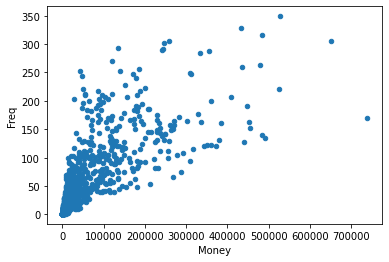

In [43]:
# コード 5.12 RFM 分析で利用するライブラリとデータ
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df=pd.read_csv('in/ds2qpr.csv')

# コード5.13 異常値の金額と来店頻度の散布図
m=df.groupby(['モニタ'],as_index=False)['金額'].sum().rename(columns={'金額':'Money'})
f=df[~df.duplicated(subset=['モニタ','日付'])].groupby(['モニタ'],as_index=False)['日付'].count().rename(columns={'日付':'Freq'})

# 散布図の描画
mf=pd.merge(m, f, on='モニタ')
display(mf.sort_values('Freq'))
mf.plot.scatter(x='Money',y='Freq')
plt.show()

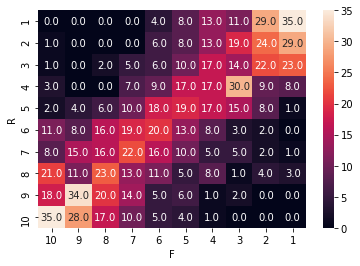

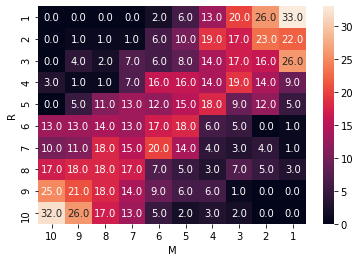

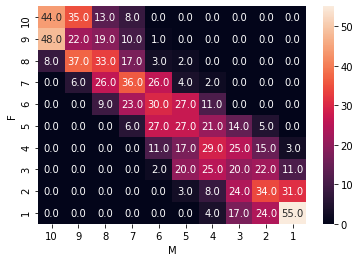

In [44]:
# コード 5.14 RFM 分析を実施するコード
# RFMの計算
rval=rDecil(df); fval=fDecil(df); mval=mDecil(df)
# RFMの結合
rfm=pd.merge(rval, fval, on='モニタ')
rfm=pd.merge(rfm, mval, on='モニタ')

# RとFでクロス集計しヒートマップの描画
rf=pd.crosstab(rfm['R'],rfm['F'])
sns.heatmap(rf,annot=True,fmt="1.1f")
plt.show()

# RとMでクロス集計しヒートマップの描画
rm=pd.crosstab(rfm['R'],rfm['M'])
sns.heatmap(rm,annot=True,fmt="1.1f")
plt.show()

# FとMでクロス集計しヒートマップの描画
fm=pd.crosstab(rfm['F'],rfm['M'])
sns.heatmap(fm,annot=True,fmt="1.1f")
plt.show()

In [45]:
# 章末問題（１）
# 来店頻度デシルの計算を利用して、cutとqcutの違いを示す

n=10 # 10つに分割

def fDecil(df):
    dff=df[~df.duplicated(subset=['モニタ','日付'])].groupby(['モニタ'],as_index=False)['日付'].count()
    dff=dff.rename(columns={'日付':'来店頻度'})
    # qcutを利用
    dff['F']=pd.qcut(dff['来店頻度'].rank(method='first'),n,labels=[10,9,8,7,6,5,4,3,2,1]) # 1が一番来店頻度多い
    # cutを利用
    dff['F2']=pd.cut(dff['来店頻度'].rank(method='first'),n,labels=[10,9,8,7,6,5,4,3,2,1]) # 1が一番来店頻度多い
    return dff


def mDecil(df):
    dfm=df.groupby(['モニタ'],as_index=False)['金額'].sum()
    dfm['M']=pd.cut(dfm['金額'],n) 
    dfm['M2']=pd.qcut(dfm['金額'],n)
    return dfm

# サンプル数が多いのでin/ds2qpr.csvを利用する
df = pd.read_csv('in/ds2qpr.csv')
# 来店頻度のqcutとcutを利用したデシルの違い
rsl= fDecil(df)
display(rsl)
# このcutとqcutの結果を確認すると同じ出力結果になっている。これはなぜだろうか？
# これはrankを利用しているからである。rankを利用することで、データの並び順に1から順番が付与される。
# その順序データを対象にqcutによる頻度の均等とcutの区分範囲を均等にしているため同じ結果になる。
# rankを利用しているのは同じ来店頻度がある場合（「1,1,1,2,3」など）にエラーになるためである。

# それでは金額デシルでランクを利用せずにデシル分割を実施してみよう
rsl= mDecil(df)
display(rsl)
# 実行結果を確認するとMとM2で区分範囲が異なることが確認できる。



,モニタ,来店頻度,F,F2
0,00J,146,2,2
1,02W,2,9,9
2,032,7,7,7
3,03t,55,4,4
4,04g,160,1,1
...,...,...,...,...
995,uy,12,6,6
996,v5,120,2,2
997,vS,131,2,2
998,z6,9,7,7


,モニタ,金額,M,M2
0,00J,229836.0,"(221273.1, 295030.8]","(168676.6, 737577.0]"
1,02W,1096.0,"(-737.577, 73757.7]","(797.0, 1988.6]"
2,032,7369.0,"(-737.577, 73757.7]","(4613.8, 11313.0]"
3,03t,44736.0,"(-737.577, 73757.7]","(26971.4, 48050.7]"
4,04g,194576.0,"(147515.4, 221273.1]","(168676.6, 737577.0]"
...,...,...,...,...
995,uy,7841.0,"(-737.577, 73757.7]","(4613.8, 11313.0]"
996,v5,371368.0,"(368788.5, 442546.2]","(168676.6, 737577.0]"
997,vS,378734.0,"(368788.5, 442546.2]","(168676.6, 737577.0]"
998,z6,3763.0,"(-737.577, 73757.7]","(1988.6, 4613.8]"


In [46]:
# 章末問題（２）
# 表記ゆれを修正するコードに「味の素　えびとひじきふんわり揚げ６個１２９ｇ」の個数とグラムを削除するコード

import re

def mkNames(df):
        chgName=[]
        for name in df['名称']:
            name=re.sub(u'[１２３４５６７８９０．]+グラム','',name)
            name=re.sub(u'[１２３４５６７８９０．]+ｋｇ','',name)
            name=re.sub(u'[１２３４５６７８９０．]+Ｋｇ','',name)
            name=re.sub(u'[１２３４５６７８９０．]+ＫＧ','',name)
            name=re.sub(u'[１２３４５６７８９０．]+ｍｌ','',name)
            name=re.sub(u'[１２３４５６７８９０．]+袋','',name)
            name=re.sub(u'[１２３４５６７８９０．]+本','',name)
            name=re.sub(u'[１２３４５６７８９０．]+缶','',name)
            name=re.sub(u'[１２３４５６７８９０．]+人前','',name)
            name=re.sub(u'[１２３４５６７８９０．]+ｇ','',name)
            name=re.sub(u'[×]$','',name)
            # 回答以下の1行を追加してみよう。全角数字と個
            name=re.sub(u'[１２３４５６７８９０．]+個','',name) # 全角数字+個を置換
            chgName.append(name)
            
        dfo=pd.DataFrame(chgName,columns=(['略称']))
        return(dfo)

df=pd.read_csv('in/itemMaster.csv')
df=df.loc[:,['名称']]
df=df.append({'名称':'味の素　えびとひじきふんわり揚げ６個１２９ｇ'},ignore_index=True) # データフレームに対象レコードを追加
display(df)

odf=mkNames(df)
display(odf)

,名称
0,あきたこまちブレンド １袋 ５ＫＧ
1,あずさワイン 無添加マスカット ７２０ｍｌ
2,いなば とりごぼう ７５ｇ×３缶
3,おやつごろ 村田製菓 芋けんぴ 袋 １００グラム
4,カルビー ポテトチップスうすしお ８０ｇ
5,カルビー ポテトチップスたらこバター ５８ｇ
6,国内産きゅうり 袋 ４本
7,山形県産あきたこまち １袋 １０ｋｇ
8,湯沢市産あきたこまち １袋 １０Ｋｇ
9,無洗米あきたこまち １袋 ５Ｋｇ


,略称
0,あきたこまちブレンド
1,あずさワイン 無添加マスカット
2,いなば とりごぼう
3,おやつごろ 村田製菓 芋けんぴ 袋
4,カルビー ポテトチップスうすしお
5,カルビー ポテトチップスたらこバター
6,国内産きゅうり 袋
7,山形県産あきたこまち
8,湯沢市産あきたこまち
9,無洗米あきたこまち


In [47]:
# 章末問題（３）
# 編集距離の閾値を小さくしたり大きくして結果を確認する

import Levenshtein

def similarTextPairs(texts,maxDist):
    pairs=[]
    for i in range(len(texts)-1):
        for j in range(i+1,len(texts)):
            len1=len(texts[i])
            len2=len(texts[j])
            dist=Levenshtein.distance(texts[i],texts[j])
            ed=0
            if len1+len2==0:
                continue
            normDist=dist/max(len1,len2)
            if normDist < maxDist:
                pairs.append([i,j,dist,normDist])
    return pairs

df=pd.read_csv('./in/itemMaster2.csv')
df['name']=df.loc[:,['略称']]

# 回答
# この閾値を変更する（小さくすると類似の条件が強くなるためより似ているものだけが出力される)
# 0.3にすると2件だけ出力される。0.2にすると1件も出力されない
# 0.8にすると11件出力される。
pairs=similarTextPairs(df['name'],0.3)

lists=[]
for pair in pairs:
    p1=df['name'][pair[0]]; p2=df['name'][pair[1]];
    dist=pair[2]; ndist=pair[3]
    x=[p1,p2,dist,ndist]
    lists.append(x)
    
dfo=pd.DataFrame(lists,columns=(['item1','item2','距離','標準化距離']))
display(dfo)



,item1,item2,距離,標準化距離
0,国内産きゅうり 袋,鳥取県産きゅうり 袋,3,0.272727
1,山形県産あきたこまち,湯沢市産あきたこまち,3,0.250000


In [48]:
# 章末問題（４）
# 顧客別の1日あたりの平均金額を利用して金額デシルを計算してみよう

n=10
def mDecil(df):
    # 回答
    # 顧客別の1日あたりの平均金額を計算するために、モニタと日付で金額を合計する
    dfm=df.groupby(['モニタ','日付'],as_index=False)['金額'].sum()
    # モニタ別に金額の平均を計算
    dfm=dfm.groupby(['モニタ'],as_index=False)['金額'].mean()
    display(dfm)
    dfm['M']=pd.qcut(dfm['金額'].rank(method='first'),n,labels=[10,9,8,7,6,5,4,3,2,1]) # 1が一番金額高い
    return dfm

df = pd.read_csv('in/id-pos.csv')
display(df)

rsl= mDecil(df)
display(rsl)


,モニタ,日付,金額,細分類名
0,A,20140401,300,牛乳
1,A,20140401,200,ヨーグルト
2,A,20140403,400,半生菓子
3,A,20140404,200,食パン
4,B,20140411,900,ワイン
5,B,20140415,800,牛肉
6,C,20140416,100,カップ麺
7,D,20140508,200,ヨーグルト
8,E,20140512,300,牛乳
9,F,20140515,400,半生菓子


,モニタ,金額
0,A,366.666667
1,B,850.000000
2,C,100.000000
3,D,200.000000
4,E,300.000000
5,F,400.000000
6,G,500.000000
7,H,600.000000
8,I,700.000000
9,J,900.000000


,モニタ,金額,M
0,A,366.666667,8
1,B,850.000000,3
2,C,100.000000,10
3,D,200.000000,10
4,E,300.000000,9
5,F,400.000000,7
6,G,500.000000,6
7,H,600.000000,5
8,I,700.000000,4
9,J,900.000000,2
